In [21]:
from hacks import sksurv_model_hack, plot_survival_function, normalize
from sksurv.tree import SurvivalTree
from sksurv.preprocessing import OneHotEncoder
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.metrics import concordance_index_censored
from concrete.ml.sklearn import DecisionTreeRegressor as FHE_DecisionTreeRegressor
import matplotlib.pyplot as plt
import random
import numpy as np

#### Train the model as usual with sksurv

In [22]:
X, y = load_veterans_lung_cancer()
X.sample(3)

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
133,64.0,large,60.0,5.0,no,test
23,65.0,smallcell,30.0,2.0,no,standard
81,58.0,squamous,70.0,13.0,no,test


In [23]:
X.shape

(137, 6)

The target as usual in survival models is represented as pairs `(censored, time-of-event)`. Censored means if the event happend or not at the time present in the target. 

In [24]:
y[:10]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [25]:
y_true = y[y["Status"]==True]
f"From a total of {y.shape[0]} observations, {y_true.shape[0]} are not censored, \
minimum suvival in days is {int(min(y['Survival_in_days']))} and maximum {int(max(y_true['Survival_in_days']))}. \
A total of {np.unique(y['Survival_in_days']).shape[0]} different time point observations is in the dataset."

'From a total of 137 observations, 128 are not censored, minimum suvival in days is 1 and maximum 999. A total of 101 different time point observations is in the dataset.'

We have to transform the categorical features to numerical. 

In [26]:
X_num = OneHotEncoder().fit_transform(X)
X_num.shape

(137, 8)

In [27]:
st = SurvivalTree()
st.fit(X_num, y)

TypeError: get_params_patched() got an unexpected keyword argument 'deep'

In [ ]:
time_points = st.unique_times_
print(time_points, len(time_points))

[  1.   2.   3.   4.   7.   8.  10.  11.  12.  13.  15.  16.  18.  19.
  20.  21.  22.  24.  25.  27.  29.  30.  31.  33.  35.  36.  42.  43.
  44.  45.  48.  49.  51.  52.  53.  54.  56.  59.  61.  63.  72.  73.
  80.  82.  83.  84.  87.  90.  92.  95.  97.  99. 100. 103. 105. 110.
 111. 112. 117. 118. 122. 123. 126. 132. 133. 139. 140. 143. 144. 151.
 153. 156. 162. 164. 177. 182. 186. 200. 201. 216. 228. 231. 242. 250.
 260. 278. 283. 287. 314. 340. 357. 378. 384. 389. 392. 411. 467. 553.
 587. 991. 999.] 101


The survival tree is able to predict a survival function for a patient

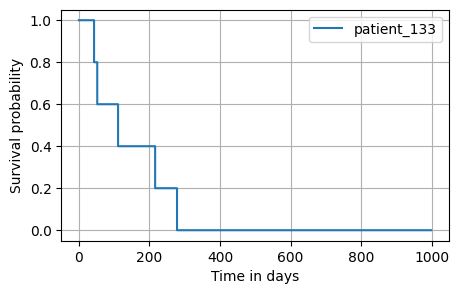

In [ ]:
# Take a single random patient. 
some_index = random.randint(0, X_num.shape[0] -1)
some_patient = X_num.iloc[some_index, :]

# Get a `StepFunction` for the given patient representing the survival function. 
surv = st.predict_survival_function(some_patient.values.reshape(1, -1))

# Plot the survival function for the patient
points_range = np.arange(0, max(time_points), 1)
risk_points = surv[0](points_range) #Index 0 as we have a single prediction. 
plot_survival_function(points_range, risk_points, f"patient_{some_index}") 

In [ ]:
internal_prediction = st.tree_.predict(some_patient.values.reshape(1, -1).astype(np.float32))
internal_prediction.shape

(1, 101, 2)

In [ ]:
internal_prediction[0, :, 1]

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

For a global evaluation, we can use Harrell’s concordance index or c-index. The interpretation is identical to the traditional area under the ROC curve metric for binary classification:

- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

In [ ]:
predictions = st.predict(X_num)
print(predictions[3])
result = concordance_index_censored(y["Status"], y["Survival_in_days"], predictions)
f"c-index is {result[0]:.5f}"

90.99999999999997


'c-index is 0.82372'

#### Prepare the model to be dealt with ConcreteML

In [ ]:
st_hacked = sksurv_model_hack(st)

#### Compile the model as usual with ConcreteML

In [ ]:
model = FHE_DecisionTreeRegressor.from_sklearn_model(st_hacked, n_bits=4)

In [ ]:
model.compile(X_num)

In [ ]:
predictions = model.predict(X_num, fhe="execute")

In [ ]:
predictions.shape

(137, 202)

The internals of the implementation of `SurvivalTree` use a regular tree regresor with multiple outputs, returning:
- The cumulative hazard function (CHF)
- The Survival Function (SF)

So the size of the outputs is `_unique_times.shape[0] * 2` and it happens that both functions are "mixed" in the even and odd positions.

The `SurvivalTree` disguised as a decision tree regressor is returning both functions with `predict`, so that we have to disentangle the two functions. 

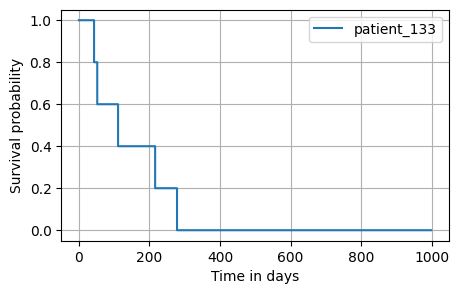

In [ ]:
prediction = predictions[some_index]
cumulative_hazard =  prediction[0::2]
survival_risk = prediction[1::2]
plot_survival_function(points_range, risk_points, f"patient_{some_index}") 

In [ ]:
survival_risk_normalized = normalize(survival_risk)
plot_survival_function(points_range, survival_risk_normalized, f"patient_{some_index}") 

NameError: name 'np' is not defined

In [ ]:
def risk_score(cumulative_hazard):
    return cumulative_hazard.sum()
risk_score(cumulative_hazard)

0.6404260562111936

In [ ]:
predictions_as_risk_scores = [risk_score(prediction[0::2]) for prediction in predictions]
result = concordance_index_censored(y["Status"], y["Survival_in_days"], predictions_as_risk_scores)
f"{result[0]:.5f}"

'0.81963'